In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import h5py
import matplotlib.pyplot as plt
'''import inflect
c2h.stringify = inflect.engine()'''
from tqdm import tqdm
from collections import Counter
import csv_to_hdf5 as c2h
import obspy
import math

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
creepmeter_metadata = pd.read_excel('../../Data/Creepmeter_list.xlsx')
print(list(creepmeter_metadata['Creepmeter_full_name']))

['Balikburnu', 'Bitterwater', 'Highway 46', 'Highway 46', 'Canyonlands', 'Cerkes', 'Fremont Winery', 'Chaman', 'Cherry', 'Hayward Palisades St #2', 'Oakland Zoo', 'Pt Pinole', 'Carr Ranch', 'Temescal', 'Cienega Winery Central', 'Cienega Winery North', 'Dead Sea', 'Dead Sea Orthogonal', 'Pipeline SSA Durmid Hill', 'East Sazlik', 'Fox Creek', 'Ferrum SSA Durmid Hill', 'GB Ridgecrest', 'GD Ridgecrest', 'Goksun', 'Gozene', 'GS Ridgecrest', 'GT Ridgecrest', 'Hamamli', 'Hollister Central', 'Hollister D St', 'Hayward, D St #1', 'Hayward Palisades St #1', 'Hayward, Rose St #1', 'Hayward, Rose St #2', 'Hayward, D St #2', 'Hassa', 'Hatay', 'Ismetpasa North Wall', 'Indian Ring SSA North Shore', 'Ismetpasa South Wall', 'Melendy Windmill', 'Karakose', 'Kirikhan', 'North Shore SSA North Shore', 'Ormanice', 'Palu North', 'Palu South', 'Petrol', 'E. Quarry SSA Mecca Hills', 'W. Quarry SSA Mecca Hills', 'R7 Ridgecrest', 'RA Ridgecrest', 'RB Ridgecrest', 'Ross Road, Imperial', 'Salt Creek SSA oblique', 

In [3]:
# Example usage
directory = '../../Data/DATA_tidied/CSV/'  # Replace with your actual directory path
files = c2h.list_files_in_directory(directory)
print(files)
try:
    Creepmeter_dataframe = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation.csv',index_col=0)
except FileNotFoundError:
    Creepmeter_dataframe = pd.DataFrame()

print(Creepmeter_dataframe)
Creepmeter_dataframe_SAC = pd.DataFrame()

['xmbc.csv', 'cha1.csv', 'crr1.csv', 'xsh1.csv', 'cfw1.csv', 'wkr1.csv', 'FCR1.csv', '.DS_Store', 'bal1.csv', 'yze1.csv', 'has1.csv', 'pas1.csv', 'orm1.csv', 'ham1.csv', 'qe30.csv', 'rr45.csv', 'c462.csv', 'sc30.csv', 'yzw1.csv', 'tas1.csv', 'hat1.csv', 'du30.csv', 'c461.csv', 'gok1.csv', 'ctm1.csv', 'kir1.csv', 'pet1.csv', 'xmd1.csv', 'xsc1.csv', 'can1.csv', 'ns45.csv', 'ds30.csv', 'inw1.csv', 'esz1.csv', 'chp1.csv', 'xmr1.csv', 'gs.csv', 'gd.csv', 'sjn1.csv', 'che1.csv', 'tep1.csv', 'coz1.csv', 'isw1.csv', 'kar1.csv', 'xgh1.csv', 'r7.csv', 'ra.csv', 'xpk1.csv', 'ir30.csv', 'gb.csv', 'pan1.csv', 'rb.csv', 'xpk2.csv', 'xrsw.csv', 'xsj3.csv', 'goz1.csv', 'xva1.csv', 'xsj2.csv', 'xta1.csv', 'qw30.csv', 'cpp1.csv', 'wsz1.csv', 'sh30.csv', 'cwn1.csv', 'xmm1.csv', 'xhr3.csv', 'fe30.csv', 'sel1.csv', 'cwc3.csv', 'xhsw.csv', 'xhr2.csv', 'siv1.csv', 'cer1.csv', 'tabc.csv', 'x461.csv', 'xhr1.csv', 'su30.csv']
    Network    Creepmeter_full_name Creepmeter_abbrv File_code  \
0       EAF         

In [4]:
del files[7]
print(files)


['xmbc.csv', 'cha1.csv', 'crr1.csv', 'xsh1.csv', 'cfw1.csv', 'wkr1.csv', 'FCR1.csv', 'bal1.csv', 'yze1.csv', 'has1.csv', 'pas1.csv', 'orm1.csv', 'ham1.csv', 'qe30.csv', 'rr45.csv', 'c462.csv', 'sc30.csv', 'yzw1.csv', 'tas1.csv', 'hat1.csv', 'du30.csv', 'c461.csv', 'gok1.csv', 'ctm1.csv', 'kir1.csv', 'pet1.csv', 'xmd1.csv', 'xsc1.csv', 'can1.csv', 'ns45.csv', 'ds30.csv', 'inw1.csv', 'esz1.csv', 'chp1.csv', 'xmr1.csv', 'gs.csv', 'gd.csv', 'sjn1.csv', 'che1.csv', 'tep1.csv', 'coz1.csv', 'isw1.csv', 'kar1.csv', 'xgh1.csv', 'r7.csv', 'ra.csv', 'xpk1.csv', 'ir30.csv', 'gb.csv', 'pan1.csv', 'rb.csv', 'xpk2.csv', 'xrsw.csv', 'xsj3.csv', 'goz1.csv', 'xva1.csv', 'xsj2.csv', 'xta1.csv', 'qw30.csv', 'cpp1.csv', 'wsz1.csv', 'sh30.csv', 'cwn1.csv', 'xmm1.csv', 'xhr3.csv', 'fe30.csv', 'sel1.csv', 'cwc3.csv', 'xhsw.csv', 'xhr2.csv', 'siv1.csv', 'cer1.csv', 'tabc.csv', 'x461.csv', 'xhr1.csv', 'su30.csv']


In [5]:
files = ['sc30.csv']

In [6]:
files.sort()
diff_all = []
count = 0
for file in tqdm(files):
    data = pd.read_csv(directory + file,index_col=0)
    try:
        #print(data['Time'].head(10))
        data['Time'] = pd.to_datetime(data['Time'],dayfirst=True)
    except KeyError:
        #print(data['Date'].head(10))
        data['Time'] = pd.to_datetime(data['Date'])
    tm_diff = np.diff(data['Time'])/ np.timedelta64(1, 'm')
    negatives = np.any(tm_diff<0)
    if negatives == True:
        where_neg = np.where(tm_diff<0)[0]
        count+=1
        print(where_neg)
        #for i in range(len(where_neg)):
            #print(data.loc[where_neg[i]-10:where_neg[i]+10])
        print(file, 'negatives!!')
    diff_all.extend(np.unique(tm_diff))
print(count)
print(files)

100%|██████████| 1/1 [00:02<00:00,  2.80s/it]

0
['sc30.csv']


SC30
metadata imported
../../Data/DATA_tidied/HDF5/SC30.h5
                        Date      Slip                Time   tm_diff
0        2004-04-16 20:00:00   0.10140 2004-04-16 20:00:00      60.0
1        2004-04-16 21:00:00   0.10140 2004-04-16 21:00:00      60.0
2        2004-04-16 22:00:00   0.10140 2004-04-16 22:00:00      60.0
3        2004-04-16 23:00:00   0.10150 2004-04-16 23:00:00      60.0
4        2004-04-17 00:00:00   0.10150 2004-04-17 00:00:00      60.0
...                      ...       ...                 ...       ...
2749844  2025-01-30 03:51:00  15.32039 2025-01-30 03:51:00       1.0
2749845  2025-01-30 03:52:00  15.32039 2025-01-30 03:52:00       1.0
2749846  2025-01-30 03:53:00  15.32039 2025-01-30 03:53:00       1.0
2749847  2025-01-30 03:54:00  15.32039 2025-01-30 03:54:00       1.0
2749848  2025-01-30 03:55:00  15.32039 2025-01-30 03:55:00  123456.0

[2749849 rows x 4 columns]


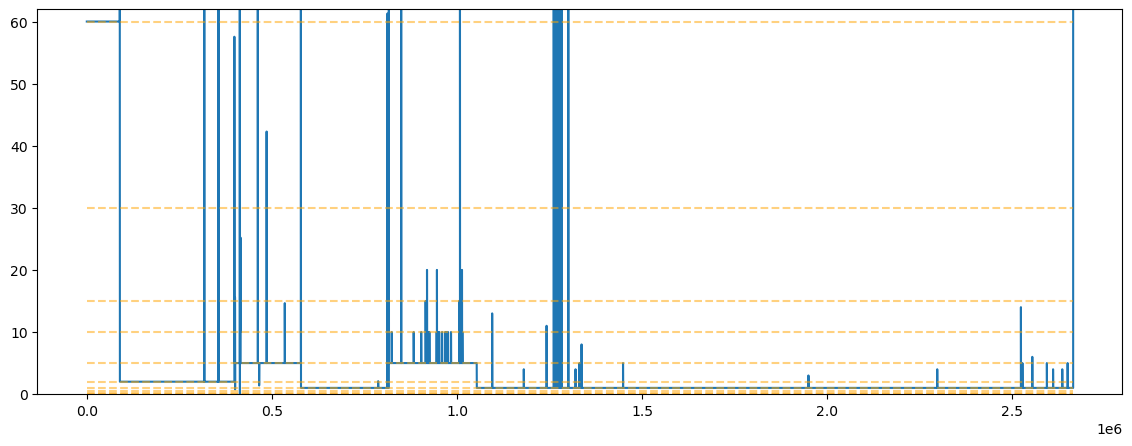

Top 5 modes and their frequencies: [(1.0, 1848212), (5.0, 415620), (2.0, 309485), (60.0, 89112), (10.0, 1498)]
[1.0, 5.0, 2.0, 60.0, 10.0]


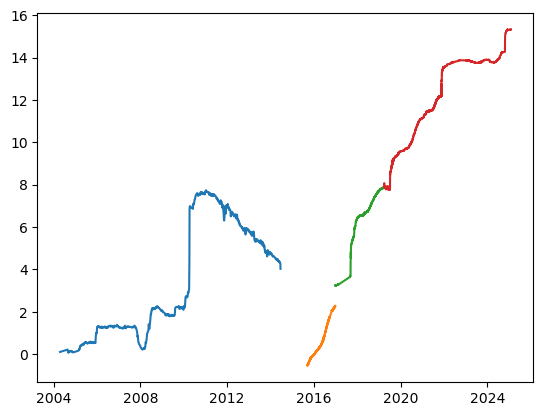

[60.0, 2.0, 5.0, 1.0] ['A', 'B', 'C', 'E']
SC30_60.0mins


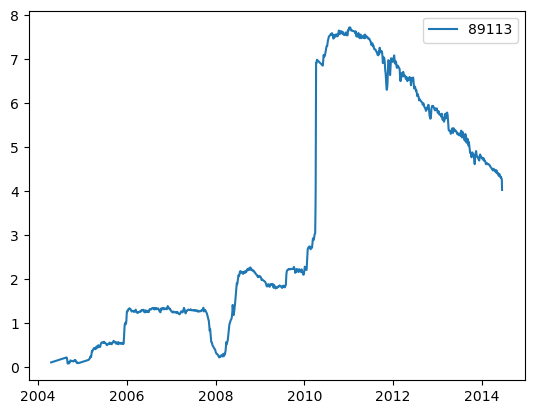

SC30_2.0mins


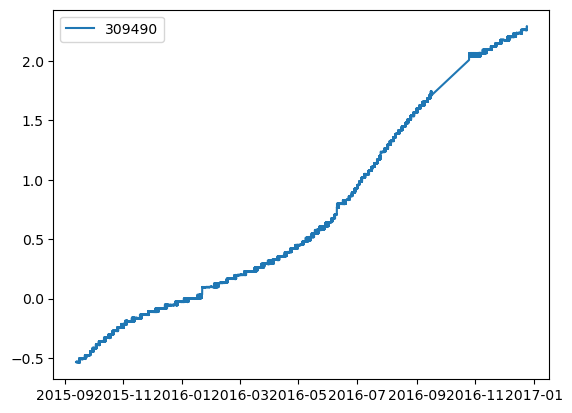

SC30_5.0mins


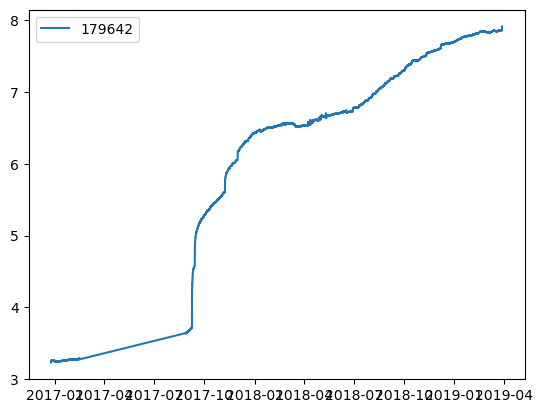

SC30_1.0mins


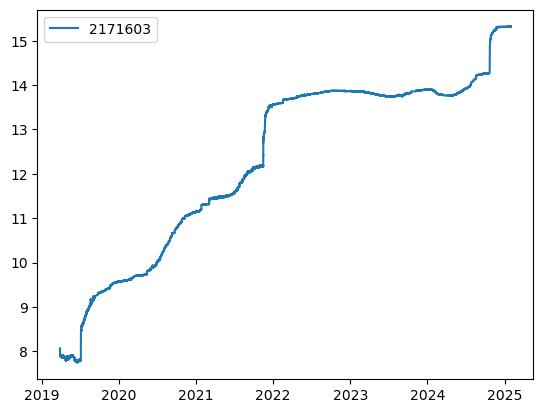

HDF5 structure
Group: /
Group: /SC30_1.0mins/
  Dataset: Slip_SC30_1.0mins, Shape: (2171603,), Dtype: float64
  Dataset: Time_SC30_1.0mins, Shape: (2171603,), Dtype: object
Group: /SC30_2.0mins/
  Dataset: Slip_SC30_2.0mins, Shape: (309490,), Dtype: float64
  Dataset: Time_SC30_2.0mins, Shape: (309490,), Dtype: object
Group: /SC30_5.0mins/
  Dataset: Slip_SC30_5.0mins, Shape: (179642,), Dtype: float64
  Dataset: Time_SC30_5.0mins, Shape: (179642,), Dtype: object
Group: /SC30_60.0mins/
  Dataset: Slip_SC30_60.0mins, Shape: (89113,), Dtype: float64
  Dataset: Time_SC30_60.0mins, Shape: (89113,), Dtype: object
Creepmeter_meta_data
    Network    Creepmeter_full_name Creepmeter_abbrv File_code  \
0       EAF              Balikburnu             BAL1      BAL1   
1      PARK              Highway 46             C461      C461   
2      PARK              Highway 46             C462      C462   
3       UTA             Canyonlands             CAN1      CAN1   
4       NAF                  Cerke

In [10]:
import importlib
importlib.reload(c2h)
try:
    del creeping_A
except NameError:
    dummy=10

try:
    del creeping_B
except NameError:
    dummy=10
try:
    del creeping_C
except NameError:
    dummy=10

try:
    del creeping_D
except NameError:
    dummy=10


sac_vs_hdf5='hdf5'
Creepmeter_dataframe_SAC = pd.DataFrame()
for file in files:
    # Extract the first 4 letters in uppercase
    abbreviation = file[:4].upper()
    print(abbreviation)
    try:
        fn = '{k}'.format(k=abbreviation)
        prefix = 'Slip'
        index_CM = np.where(creepmeter_metadata['Creepmeter_abbrv']==abbreviation)[0][0]
        full_name = creepmeter_metadata['Creepmeter_full_name'].iloc[index_CM]
        latitude = creepmeter_metadata['Latitude'].iloc[index_CM]
        longitude = creepmeter_metadata['Longitude'].iloc[index_CM]
        depth = creepmeter_metadata['Depth'].iloc[index_CM]
        length = creepmeter_metadata['Length'].iloc[index_CM]
        obliquity = creepmeter_metadata['Obliquity'].iloc[index_CM]
        network = creepmeter_metadata['Network'].iloc[index_CM]
        full_name = creepmeter_metadata['Creepmeter_full_name'].iloc[index_CM]
        print('metadata imported')
        hdf5_path = '../../Data/DATA_tidied/HDF5/' + fn +'.h5'
        sac_path = '../../Data/DATA_tidied/SAC/' + fn +'.SAC'

        if sac_vs_hdf5 == 'hdf5':
            path = hdf5_path
        elif sac_vs_hdf5 == 'sac':
            path=sac_path
        print(path)
        if not os.path.isfile(path):
            data = pd.read_csv(directory + file,index_col=0)
            try:
                data['Time'] = pd.to_datetime(data['Time'])
            except KeyError:
                data['Time'] = pd.to_datetime(data['Date'])

            tm_diff = np.diff(data['Time'])/ np.timedelta64(1, 'm')
            tm_diff = np.append(tm_diff,123456)
            #tm_diff = c2h.round_to_nearest_half(tm_diff)
            data['tm_diff'] = tm_diff
            data.dropna(inplace=True)
            #data['tm_diff'] = c2h.round_to_nearest_half(data['tm_diff'])
            data.reset_index(inplace=True,drop=True)
            print(data)

            boolarr = tm_diff <1/60
            same_time = tm_diff[boolarr] 

            if len(same_time) >0:
                datapoint_to_drop = np.where(tm_diff <1/60)[0][0]
                data.drop(datapoint_to_drop,inplace=True)
                data.reset_index(inplace=True)
                data.drop(['index'],axis=1,inplace=True)
                boolarr_diff = tm_diff >= 1/60
                tm_diff = tm_diff[boolarr_diff]
            data.drop(data.loc[data.Time.isnull()].index,inplace=True)
            data.reset_index(inplace=True,drop=True) 
            data['Slip'] = data['Slip'].astype(float)

            plt.figure(figsize=(14,5))
            ax = plt.subplot(1,1,1)
            plt.plot(tm_diff)
            plt.ylim(0,62)
            plt.hlines([1/60,1/6,1/2,1,2,5,10,15,30,60],xmin=0,xmax=len(tm_diff),colors='orange',linestyles='--',alpha=0.5)
            plt.show()

            allowed_modes = [1/60,1/6,1/2,1,2,5,10,15,30,60]
            top_4_modes = c2h.find_top_modes(tm_diff, 5,allowed_modes)
            print("Top 5 modes and their frequencies:", top_4_modes)
            no_mode = input('how many sampling frequencies?')
            reversal = input('does the smaple rate revert to an earlier one? (y/n)')
            periods = []
            for q in range(int(no_mode)):
                periods.append(top_4_modes[q][0])
            print(periods)

            if abbreviation =='SC30':
                creeping_A = data.iloc[:89113]
                creeping_B = data.iloc[89113:398603]
                creeping_C = data.iloc[398603:578245]#413792]
                #creeping_D = data.iloc[413792:415271]
                #creeping_C_2 = data.iloc[415271:578245]
                #creeping_C = pd.concat([creeping_C,creeping_C_2],ignore_index=True)
                creeping_E = data.iloc[578245:]
                #del creeping_C_2 

                plt.figure()
                plt.plot(pd.to_datetime(creeping_A['Date']),creeping_A['Slip'])
                plt.plot(pd.to_datetime(creeping_B['Date']),creeping_B['Slip'])
                plt.plot(pd.to_datetime(creeping_C['Date']),creeping_C['Slip'])
                #plt.plot(pd.to_datetime(creeping_D['Date']),creeping_D['Slip'])
                plt.plot(pd.to_datetime(creeping_E['Date']),creeping_E['Slip'])
                plt.show()

            if len(periods)==4:
                pairs = [(periods[i], periods[j]) for i in range(4) for j in range(i + 1, 4)]
                indices = []
                
                # Calculate indices based on transformations for each pair
                for k, g in pairs:
                    idx1 = eval('c2h.{k}_to_{g}(tm_diff)'.format(k=c2h.stringify(k), g=c2h.stringify(g)))
                    idx2 = eval('c2h.{k}_to_{g}(tm_diff)'.format(k=c2h.stringify(g), g=c2h.stringify(k)))
                    indices.extend([idx1, idx2])
                
                # Sort and get the unique indices, which serve as the transition points
                indices = sorted(indices)
                print(indices)
                unique_ind = np.unique(indices)
                print("Unique Indices:", unique_ind)


                if abbreviation == 'DU30':
                    T10_to_5  =115226
                    T5_to_10 = 435982
                    T10_to_1 = 460833
                    T1_to_5 = 460860
                    T5_to_30 = 1187431
                    T30_to_1 = 1230931
                                    
                    creeping_A = data.iloc[:T10_to_5]
                    creeping_B = data.loc[T10_to_5:T5_to_10] 
                    creeping_A_2 = data.iloc[T5_to_10:T10_to_1]
                    creeping_C = data.iloc[T10_to_1:T1_to_5]
                    creeping_B_2 = data.iloc[T1_to_5:T5_to_30]
                    creeping_D = data.iloc[T5_to_30:T30_to_1]
                    creeping_C_2 = data.iloc[T30_to_1:]

                    creeping_A = pd.concat([creeping_A,creeping_A_2],ignore_index=True)
                    creeping_B = pd.concat([creeping_B,creeping_B_2],ignore_index=True)
                    creeping_C = pd.concat([creeping_C,creeping_C_2],ignore_index=True)
                    del creeping_A_2,creeping_B_2,creeping_C_2 
                       # From start to 'a' (exclusive)
                elif abbreviation == 'FE30':
                    a = unique_ind[1]
                    creeping_A = data.iloc[:a]
                    the_rest = data.iloc[a:]
                    the_rest.reset_index(inplace=True,drop=True)
                    for k, g in pairs:
                        idx1 = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k=c2h.stringify(k), g=c2h.stringify(g)))
                        idx2 = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k=c2h.stringify(g), g=c2h.stringify(k)))
                        indices.extend([idx1, idx2])
                
                    # Sort and get the unique indices, which serve as the transition points
                    indices = sorted(indices)
                    print(indices)
                    unique_ind = np.unique(indices)
                    print("Unique Indices:", unique_ind)
                    b = unique_ind[1]
                    creeping_B = the_rest.iloc[:b]
                    creeping_A_2 = the_rest.iloc[b:unique_ind[2]]
                    creeping_C = the_rest.iloc[unique_ind[2]:unique_ind[5]]
                    creeping_D = the_rest.iloc[unique_ind[5]:]
                    creeping_A = pd.concat([creeping_A,creeping_A_2],ignore_index=True)
                elif abbreviation =='RR45':
                    T30_to_10 = 57478
                    T10_to_5 = 190438
                    T5_to_1 = 391170

                    creeping_A = data.iloc[:T30_to_10]
                    creeping_B = data.loc[T30_to_10:T10_to_5] 
                    creeping_C = data.iloc[T10_to_5+1:T5_to_1]
                    creeping_D = data.iloc[T5_to_1:]
                elif abbreviation == 'SU30':
                    T2_to_5 = 16666
                    T5_to_10 = 231349
                    T10_to_15 = 308074
                    T15_to_30 = 359677
                    T30_to_5 = 503020
                    T5_to_1 = 584077

                    creeping_A = data.iloc[:T2_to_5]
                    creeping_B = data.loc[T2_to_5:T5_to_10] 
                    creeping_C = data.iloc[T5_to_10:T10_to_15]
                    creeping_D = data.iloc[T10_to_15:T15_to_30]
                    creeping_B_2 = data.iloc[T15_to_30:T30_to_5]
                    creeping_E = data.iloc[T5_to_1:]
                    creeping_B = pd.concat([creeping_B,creeping_B_2],ignore_index=True)
                elif abbreviation == 'NS45':
                    T30_to_5 = unique_ind[1]
                    T5_to_10  = unique_ind[2]
                    T10_to_1 = unique_ind[3]
                    creeping_A = data.iloc[:T30_to_5]
                    creeping_B = data.iloc[T30_to_5:T5_to_10]
                    creeping_C = data.iloc[T5_to_10:T10_to_1]
                    creeping_D = data.iloc[T10_to_1:]

                    
                
                print(creeping_A)
                print(creeping_B)
                print(creeping_C)
                print(creeping_D)

            elif len(periods)==3:
                a = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                b = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
                c = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[2])))
                d = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[0])))
                e = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[2])))
                f = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[1])))

                indices = sorted([a,b,c,d,e,f])
                unique_ind = np.unique(indices)
                print(unique_ind)
                creeping_A = data.iloc[:unique_ind[1]]      # From start to 'a' (exclusive)
                the_rest = data.iloc[unique_ind[1]:]

                if reversal == 'y':
                    the_rest.reset_index(inplace=True,drop=True)
                    a = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                    b = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
                    c = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[2])))
                    d = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[0])))
                    e = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[2])))
                    f = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[2]), g = c2h.stringify(periods[1])))
                    indices = sorted([a,b,c,d,e,f])
                    unique_ind = np.unique(indices)

                    print(unique_ind)
                    if abbreviation == 'CHE1':
                        a = 87593
                        b = 617992
                    
                    indices = np.unique([a,b])
                    print(indices)

                    creeping_B = the_rest.iloc[:indices[0]]
                    creeping_D = the_rest.iloc[indices[0]:indices[1]]
                    creeping_C = the_rest.iloc[indices[1]:]
                    creeping_A = pd.concat([creeping_A,creeping_D],ignore_index=True)
                    creeping_B.reset_index(inplace=True,drop=True)
                    creeping_C.reset_index(inplace=True,drop=True)
                    del creeping_D




                else:
                    creeping_B = data.iloc[unique_ind[1]:unique_ind[2]]    # From 'a' (inclusive) to 'b' (exclusive)
                    creeping_C = data.iloc[unique_ind[2]:]     # From 'b' (inclusive) to 'c' (exclusive)
                    
                    creeping_A.reset_index(inplace=True,drop=True)
                    creeping_B.reset_index(inplace=True,drop=True)
                    creeping_C.reset_index(inplace=True,drop=True)
                
                print(creeping_A)
                print(creeping_B)
                print(creeping_C)


            elif len(periods) ==2:
                if abbreviation == 'SH30':
                    T5_to_1a = 179139
                    T1_to_5a = 407469
                    T5_to_1b = 513272
                    T1_to_5b = 594936

                    creeping_A = data.iloc[:T5_to_1a]
                    creeping_B = data.iloc[T5_to_1a:T1_to_5a]
                    creeping_A_2 = data.iloc[T1_to_5a:T5_to_1b]
                    creeping_B_2 = data.iloc[T5_to_1b:T1_to_5b]
                    creeping_A_3 = data.iloc[T1_to_5b:]

                    creeping_A = pd.concat([creeping_A,creeping_A_2],ignore_index=True)
                    creeping_A = pd.concat([creeping_A,creeping_A_3],ignore_index=True)
                    creeping_B = pd.concat([creeping_B,creeping_B_2],ignore_index=True)
                else:
                    a = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                    b = eval('c2h.{k}_to_{g}(tm_diff)'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))

                    indices = sorted([a,b])
                    unique_ind = np.unique(indices)
                    creeping_A = data.iloc[:unique_ind[1]]
                    the_rest = data.iloc[unique_ind[1]:]
                    
                    if reversal == 'y':
                        the_rest.reset_index(inplace=True,drop=True)
                        a = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[0]), g = c2h.stringify(periods[1])))
                        b = eval('c2h.{k}_to_{g}(the_rest["tm_diff"])'.format(k = c2h.stringify(periods[1]), g = c2h.stringify(periods[0])))
                        print(a,b)
                        if abbreviation == 'R7' or abbreviation == 'RB':
                            a = 17179
                        indices = np.unique([a,b])
                        print(indices)

                        creeping_B = the_rest.iloc[indices[0]:indices[1]]
                        creeping_C  = the_rest.iloc[indices[1]:]
                        
                        creeping_A = pd.concat([creeping_A,creeping_C],ignore_index=True)
                        creeping_B.reset_index(inplace=True,drop=True)
                        del creeping_C

                    else:
                        creeping_B = data.iloc[unique_ind[1]:]
                        creeping_A.reset_index(inplace=True,drop=True)
                        creeping_B.reset_index(inplace=True,drop=True)

                print(creeping_A)
                print(creeping_B)

            elif len(periods) == 1:
                creeping_A = data.iloc[:]
                print(creeping_A)
            
            
            Number_of_splits = []
            Sampling_rates_variable = []
            try:
                sampling_A = c2h.find_top_modes(creeping_A['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_A)
                Number_of_splits.append('A')
            except (IndexError, NameError, KeyError):
                sampling_A = 0

            try:
                sampling_B = c2h.find_top_modes(creeping_B['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_B)
                Number_of_splits.append('B')
            except (IndexError, NameError, KeyError):
                sampling_B = 0

            try:
                sampling_C = c2h.find_top_modes(creeping_C['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_C)
                Number_of_splits.append('C')
            except (IndexError, NameError, KeyError):
                sampling_C = 0

            try:
                sampling_D = c2h.find_top_modes(creeping_D['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_D)
                Number_of_splits.append('D')
            except (IndexError, NameError, KeyError):
                sampling_D = 0

            try:
                sampling_E = c2h.find_top_modes(creeping_E['tm_diff'],1,allowed_modes)[0][0]
                Sampling_rates_variable.append(sampling_E)
                Number_of_splits.append('E')
            except (IndexError, NameError, KeyError):
                sampling_E = 0

            print(Sampling_rates_variable,Number_of_splits)

            
            

            with h5py.File(path, 'w') as f:
                f.attrs['author'] = 'Daniel B. Gittins'
                f.attrs['network'] = network
                f.attrs['latitude'] = latitude
                f.attrs['longitude'] = longitude
                f.attrs['depth'] = depth
                f.attrs['length'] = length
                f.attrs['obliquity'] = obliquity
                # Create a group to store both waves together
                for i in range(len(Number_of_splits)):
                    smpl_rate = Sampling_rates_variable[i]
                    group_name = fn+'_{k}mins'.format(k=smpl_rate)
                    print(group_name)
                    time_data = eval('creeping_{k}.Time'.format(k=Number_of_splits[i]))
                    # Assuming 'data['Time']' is your pandas Series of datetime objects
                    datetime_strings = time_data.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()

                    dependent_data = eval('creeping_{k}.Slip'.format(k=Number_of_splits[i])).tolist()
                    plt.figure()
                    plt.plot(time_data,dependent_data,label=len(dependent_data))
                    plt.legend()
                    plt.show()
                    group = f.create_group(group_name)
                    # Create datasets for time and dependent variable in the group
                    group.create_dataset('Time_{p}_{k}mins'.format(p=abbreviation,k=smpl_rate), data=datetime_strings)
                    group.create_dataset('Slip_{p}_{k}mins'.format(p=abbreviation,k=smpl_rate), data=dependent_data)
                
                    
                    # Store metadata about the dependent variable
                    if Sampling_rates_variable[i] >=1:
                        description = f"Slip for {abbreviation} at {smpl_rate} minute sampling"
                    else:
                        description = f"Slip for {abbreviation} at {smpl_rate*60} second sampling"
                    group.attrs['description'] = description

                    
                    # Optional: Store additional metadata (e.g., units, sampling rate)
                    starttime = eval('creeping_{k}.Time.iloc[0]'.format(k=Number_of_splits[i]))
                    endtime = eval('creeping_{k}.Time.iloc[-1]'.format(k=Number_of_splits[i]))
                    group.attrs['sampling_rate'] = Sampling_rates_variable[i]  # Example: 100 Hz sampling rate (10 ms interval)
                    group.attrs['time_units'] = 'minutes'     # Time units
                    group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
                    group.attrs['channel'] = 'slip'
                    group.attrs['starttime'] = starttime.strftime('%Y-%m-%d %H:%M:%S')
                    group.attrs['delta'] = 60*Sampling_rates_variable[i]
                    instrument = pd.DataFrame({'Network':[network],'Creepmeter_full_name':[full_name],'Creepmeter_abbrv':[abbreviation],'File_code':[fn],
                                            'Start Time':[starttime],'End Time':[endtime],'Sampling rate, mins':[smpl_rate],
                                            'Latitude':[latitude],'Longitude':[longitude],'Description':[description],'Depth':[depth],'Length':[length],
                                            'Obliquity':[obliquity],'group_name':group_name})
                    Creepmeter_dataframe = pd.concat([Creepmeter_dataframe,instrument],ignore_index=True)
                try:
                    del creeping_A
                except NameError:
                    dummy=10

                try:
                    del creeping_B
                except NameError:
                    dummy=10
                try:
                    del creeping_C
                except NameError:
                    dummy=10

                try:
                    del creeping_D
                except NameError:
                    dummy=10


                print('HDF5 structure')
                c2h.print_hdf5_structure('../../Data/DATA_tidied/HDF5/' + fn +'.h5')
                Creepmeter_dataframe.drop_duplicates(inplace=True)
                Creepmeter_dataframe.reset_index(inplace=True,drop=True)
                Creepmeter_dataframe.to_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation.csv')
                print('Creepmeter_meta_data')
                print(Creepmeter_dataframe)
    except IndexError:
        dummy=10




In [ ]:
data.iloc[578246:1100000]

In [ ]:

creeping_E

In [ ]:
Creepmeter_dataframe

In [ ]:
T10_to_5  =115226
T5_to_10 = 435982
T10_to_1 = 460833
T1_to_5 = 460860
T5_to_30 = 1187431
T30_to_1 = 1230931

In [ ]:
np.where(tm_diff==2)

Adding Temperature

In [6]:
Temp = pd.read_csv('../../Data/DATA_tidied/CSV/Temperature/SaltCreek_Temp.csv',index_col=0)

In [7]:
Temp['Date'] = pd.to_datetime(Temp['Date'])

In [8]:
Temp

,Date,degC
0,2004-04-16 20:10:00,27.7652
1,2004-04-16 20:20:00,27.7584
2,2004-04-16 20:30:00,27.7517
3,2004-04-16 20:40:00,27.7449
4,2004-04-16 20:50:00,27.7381
...,...,...
2924594,2025-01-30 03:51:00,15.9600
2924595,2025-01-30 03:52:00,15.9400
2924596,2025-01-30 03:53:00,15.9100
2924597,2025-01-30 03:54:00,15.8900


In [9]:
abbreviation = 'SC30'

In [10]:
if abbreviation == 'SH30':
    T5_to_1a = 179139
    T1_to_5a = 407469
    T5_to_1b = 513272
    T1_to_5b = 594936

    creeping_A = Temp.iloc[:T5_to_1a]
    creeping_B = Temp.iloc[T5_to_1a:T1_to_5a]
    creeping_A_2 = Temp.iloc[T1_to_5a:T5_to_1b]
    creeping_B_2 = Temp.iloc[T5_to_1b:T1_to_5b]
    creeping_A_3 = Temp.iloc[T1_to_5b:]

    creeping_A = pd.concat([creeping_A,creeping_A_2],ignore_index=True)
    creeping_A = pd.concat([creeping_A,creeping_A_3],ignore_index=True)
    creeping_B = pd.concat([creeping_B,creeping_B_2],ignore_index=True)
    # 5 min sampling
    time_data_A = creeping_A['Date']
    datetime_strings = time_data_A.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    dependent_data = creeping_A['degC'].tolist()

    hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
    with h5py.File(hdf5_path, 'a') as f:
        del f['Temperature']

        group = f.create_group('Temperature_5T')
        # Create datasets for time and dependent variable in the group
        group.create_dataset('Time_{p}_5_mins'.format(p=abbreviation), data=datetime_strings)
        group.create_dataset('Temperature_{p}_5_mins'.format(p=abbreviation), data=np.array(dependent_data, dtype=np.float64))
        group.attrs['Units'] = 'Celsius'
        group.attrs['Start date'] = datetime_strings[0]
        group.attrs['End date'] = datetime_strings[-1]

    # 1 min sampling
    time_data_B = creeping_B['Date']
    datetime_strings = time_data_B.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    dependent_data = creeping_B['degC'].tolist()

    hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
    with h5py.File(hdf5_path, 'a') as f:
        #del f['Orthogonal_1T']
        group = f.create_group('Temperature_1T')
        # Create datasets for time and dependent variable in the group
        group.create_dataset('Time_{p}_1_mins'.format(p=abbreviation), data=datetime_strings)
        group.create_dataset('Temperature_{p}_1_mins'.format(p=abbreviation), data=np.array(dependent_data, dtype=np.float64))
        group.attrs['Units'] = 'Celsius'
        group.attrs['Start date'] = datetime_strings[0]
        group.attrs['End date'] = datetime_strings[-1]



else:
    time_data = Temp['Date']
    datetime_strings = time_data.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    dependent_data = Temp['degC'].tolist()
    hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
    with h5py.File(hdf5_path, 'a') as f:
        #del f['Temperature']
        group = f.create_group('Temperature')
        # Create datasets for time and dependent variable in the group
        group.create_dataset('Time_{p}'.format(p=abbreviation), data=datetime_strings)
        group.create_dataset('Temperature_{p}'.format(p=abbreviation), data=np.array(dependent_data, dtype=np.float64))
        group.attrs['Units'] = 'Celsius'
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

HDF5 structure
Group: /
Group: /SC30_1.0mins/
  Dataset: Slip_SC30_1.0mins, Shape: (2171603,), Dtype: float64
  Dataset: Time_SC30_1.0mins, Shape: (2171603,), Dtype: object
Group: /SC30_2.0mins/
  Dataset: Slip_SC30_2.0mins, Shape: (309490,), Dtype: float64
  Dataset: Time_SC30_2.0mins, Shape: (309490,), Dtype: object
Group: /SC30_5.0mins/
  Dataset: Slip_SC30_5.0mins, Shape: (179642,), Dtype: float64
  Dataset: Time_SC30_5.0mins, Shape: (179642,), Dtype: object
Group: /SC30_60.0mins/
  Dataset: Slip_SC30_60.0mins, Shape: (89113,), Dtype: float64
  Dataset: Time_SC30_60.0mins, Shape: (89113,), Dtype: object
Group: /Temperature/
  Dataset: Temperature_SC30, Shape: (2924599,), Dtype: float64
  Dataset: Time_SC30, Shape: (2924599,), Dtype: object


Daily

In [ ]:
Daily = pd.read_csv('../../Data/DATA_tidied/CSV/Daily/xva1_day.csv',index_col=0)
Daily

In [ ]:
abbreviation = 'XVA1'

In [ ]:
datetime_strings = Daily['Time'].tolist()
dependent_data = Daily['Slip'].tolist()
hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
with h5py.File(hdf5_path, 'a') as f:
    #del f['Daily measurements']
    group = f.create_group('Daily_measurements')
    # Create datasets for time and dependent variable in the group
    group.create_dataset('Time_{p}_daily'.format(p=abbreviation), data=datetime_strings)
    group.create_dataset('Slip_{p}_daily'.format(p=abbreviation), data=dependent_data)
    group.attrs['Units_slip'] =  'millimetres'
    group.attrs['Start date'] = datetime_strings[0]
    group.attrs['End date'] = datetime_strings[-1]
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

Manual

In [ ]:
Manual = pd.read_csv('../../Data/DATA_tidied/CSV/Manual/bit1_man.csv',index_col=0)
Manual

In [ ]:
abbreviation = 'BIT1'

In [ ]:
datetime_strings = Manual['Time'].tolist()
dependent_data = Manual['Slip'].tolist()
hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
with h5py.File(hdf5_path, 'a') as f:
    del f['Manual_measurements']
    group = f.create_group('Manual_measurements')
    # Create datasets for time and dependent variable in the group
    group.create_dataset('Time_{p}_Manual'.format(p=abbreviation), data=datetime_strings)
    group.create_dataset('Slip_{p}_Manual'.format(p=abbreviation), data=dependent_data)
    group.attrs['Units_slip'] =  'millimetres'
    group.attrs['Start date'] = datetime_strings[0]
    group.attrs['End date'] = datetime_strings[-1]
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

Orthogonal

In [11]:
Ortho = pd.read_csv('../../Data/DATA_tidied/CSV/Orthogonal/SaltCreek_Orthogonal.csv',index_col=0)
Ortho['Date'] = pd.to_datetime(Ortho['Date'])
tm_diff = np.diff(Ortho['Date'])/ np.timedelta64(1, 'm')
Ortho['diff'] = np.append(tm_diff,123456)
Ortho

,Date,Ortho,diff
0,2016-12-24 20:54:16,3.31530,5.0
1,2016-12-24 20:59:16,3.29700,5.0
2,2016-12-24 21:04:16,3.29280,5.0
3,2016-12-24 21:09:16,3.29260,5.0
4,2016-12-24 21:14:16,3.29260,5.0
...,...,...,...
2155686,2025-01-30 03:51:00,6.95197,1.0
2155687,2025-01-30 03:52:00,6.95197,1.0
2155688,2025-01-30 03:53:00,6.95197,1.0
2155689,2025-01-30 03:54:00,6.95197,1.0


In [12]:
abbreviation = 'SC30'

In [13]:
if abbreviation == 'SH30':
    T5_to_1a = 179139
    T1_to_5a = 407469
    T5_to_1b = 513272
    T1_to_5b = 594936

    creeping_A = Ortho.iloc[:T5_to_1a]
    creeping_B = Ortho.iloc[T5_to_1a:T1_to_5a]
    creeping_A_2 = Ortho.iloc[T1_to_5a:T5_to_1b]
    creeping_B_2 = Ortho.iloc[T5_to_1b:T1_to_5b]
    creeping_A_3 = Ortho.iloc[T1_to_5b:]

    creeping_A = pd.concat([creeping_A,creeping_A_2],ignore_index=True)
    creeping_A = pd.concat([creeping_A,creeping_A_3],ignore_index=True)
    creeping_B = pd.concat([creeping_B,creeping_B_2],ignore_index=True)
    # 5 min sampling
    time_data_A = creeping_A['Date']
    datetime_strings = time_data_A.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    dependent_data = creeping_A['Ortho'].tolist()
    starttime = time_data_A.iloc[0]

    hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
    with h5py.File(hdf5_path, 'a') as f:
        del f['Orthogonal_5T']
        group = f.create_group('Orthogonal_5T')
        # Create datasets for time and dependent variable in the group
        group.create_dataset('Time_{p}_5_mins_Orthogonal'.format(p=abbreviation), data=datetime_strings)
        group.create_dataset('Slip_{p}_5_mins_Orthogonal'.format(p=abbreviation), data=dependent_data)
        group.attrs['Units_Orthogonal'] =  'millimetres'
        group.attrs['Start date'] = datetime_strings[0]
        group.attrs['End date'] = datetime_strings[-1]
        group.attrs['sampling_rate'] = 5  # Example: 100 Hz sampling rate (10 ms interval)
        group.attrs['time_units'] = 'minutes'     # Time units
        group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
        group.attrs['channel'] = 'ortho'
        group.attrs['starttime'] = starttime.strftime('%Y-%m-%d %H:%M:%S')
        group.attrs['delta'] = 60*5
                        

    # 1 min sampling
    time_data_B = creeping_B['Date']
    datetime_strings = time_data_B.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    dependent_data = creeping_B['Ortho'].tolist()

    hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
    with h5py.File(hdf5_path, 'a') as f:
        del f['Orthogonal_1T']
        group = f.create_group('Orthogonal_1T')
        # Create datasets for time and dependent variable in the group
        group.create_dataset('Time_{p}_1_mins_Orthogonal'.format(p=abbreviation), data=datetime_strings)
        group.create_dataset('Slip_{p}_1_mins_Orthogonal'.format(p=abbreviation), data=dependent_data)
        group.attrs['Units_Orthogonal'] =  'millimetres'
        group.attrs['Start date'] = datetime_strings[0]
        group.attrs['End date'] = datetime_strings[-1]
        group.attrs['sampling_rate'] = 1  # Example: 100 Hz sampling rate (10 ms interval)
        group.attrs['time_units'] = 'minutes'     # Time units
        group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
        group.attrs['channel'] = 'ortho'
        group.attrs['starttime'] = starttime.strftime('%Y-%m-%d %H:%M:%S')
        group.attrs['delta'] = 60*1

In [14]:
time_data = Ortho['Date']
datetime_strings = time_data.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
dependent_data = Ortho['Ortho'].tolist()
hdf5_path = '../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation)
with h5py.File(hdf5_path, 'a') as f:
    #del f['Orthogonal']
    group = f.create_group('Orthogonal')
    # Create datasets for time and dependent variable in the group
    group.create_dataset('Time_{p}_Orthogonal'.format(p=abbreviation), data=datetime_strings)
    group.create_dataset('Slip_{p}_Orthogonal'.format(p=abbreviation), data=dependent_data)
    group.attrs['Units_Orthogonal'] =  'millimetres'
    group.attrs['Start date'] = datetime_strings[0]
    group.attrs['End date'] = datetime_strings[-1]
print('HDF5 structure')
c2h.print_hdf5_structure(hdf5_path)

HDF5 structure
Group: /
Group: /Orthogonal/
  Dataset: Slip_SC30_Orthogonal, Shape: (2155691,), Dtype: float64
  Dataset: Time_SC30_Orthogonal, Shape: (2155691,), Dtype: object
Group: /SC30_1.0mins/
  Dataset: Slip_SC30_1.0mins, Shape: (2171603,), Dtype: float64
  Dataset: Time_SC30_1.0mins, Shape: (2171603,), Dtype: object
Group: /SC30_2.0mins/
  Dataset: Slip_SC30_2.0mins, Shape: (309490,), Dtype: float64
  Dataset: Time_SC30_2.0mins, Shape: (309490,), Dtype: object
Group: /SC30_5.0mins/
  Dataset: Slip_SC30_5.0mins, Shape: (179642,), Dtype: float64
  Dataset: Time_SC30_5.0mins, Shape: (179642,), Dtype: object
Group: /SC30_60.0mins/
  Dataset: Slip_SC30_60.0mins, Shape: (89113,), Dtype: float64
  Dataset: Time_SC30_60.0mins, Shape: (89113,), Dtype: object
Group: /Temperature/
  Dataset: Temperature_SC30, Shape: (2924599,), Dtype: float64
  Dataset: Time_SC30, Shape: (2924599,), Dtype: object


In [ ]:
with h5py.File(hdf5_path, 'r+') as f:
    f.attrs['obliquity'] = 30

In [ ]:
if abbreviation == 'SH30':
    T5_to_1a = 179139
    T1_to_5a = 407469
    T5_to_1b = 513272
    T1_to_5b = 594936

    creeping_A = data.iloc[:T5_to_1a]
    creeping_B = data.iloc[T5_to_1a:T1_to_5a]
    creeping_A_2 = data.iloc[T1_to_5a:T5_to_1b]
    creeping_B_2 = data.iloc[T5_to_1b:T1_to_5b]
    creeping_A_3 = data.iloc[T1_to_5b:]

    creeping_A = pd.concat([creeping_A,creeping_A_2],ignore_index=True)
    creeping_A = pd.concat([creeping_A,creeping_A_3],ignore_index=True)
    creeping_B = pd.concat([creeping_B,creeping_B_2],ignore_index=True)

HDF5 to SAC

Code below is for importing into Igor

In [ ]:
#pragma TextEncoding = "UTF-8"
#pragma rtGlobals=3
#pragma DefaultTab={3,20,4}

// Creates a date/time wave from a date wave stored as text in YYYY-MM-DD format
// and a time wave stored as text in HH:MM:YY format.
// Example:
//      Make/O/T wDateAsText = {"2016-08-15", "2016-08-15"}
//      Make/O/T wTimeAsText = {"19:01:00", "19:01:18"}
//      TextWavesToDateTimeWave(wDateAsText, wTimeAsText, "wDateTime")
//      Edit wDateTime

Function ConvertTextToDateTime(dateTimeAsText)
    String dateTimeAsText       // Assumed in YYYY-MM-DD HH:MM:SS format
    
    Variable dt
    Variable year, month, day
    Variable hour, minute, second

    // Use sscanf to parse the full datetime string
    sscanf dateTimeAsText, "%d-%d-%d %d:%d:%d", year, month, day, hour, minute, second
    
    // Convert the date part to seconds since the epoch
    dt = Date2Secs(year, month, day)
    
    // Calculate the time of day in seconds
    Variable timeOfDay = 3600 * hour + 60 * minute + second
    
    // Add the time of day to the date
    dt += timeOfDay
    
    return dt
End


Function/WAVE TextWavesToDateTimeWave(dateTimeAsTextWave, outputWaveName)
    WAVE/T dateTimeAsTextWave       // Assumed in YYYY-MM-DD HH:MM:SS format
    String outputWaveName

    Variable numPoints = numpnts(dateTimeAsTextWave)
    Make/O/D/N=(numPoints) $outputWaveName
    WAVE wOut = $outputWaveName
    SetScale d, 0, 0, "dat", wOut
   
    Variable i
    for(i=0; i<numPoints; i+=1)
        String dateTimeAsText = dateTimeAsTextWave[i]
        Variable dt = ConvertTextToDateTime(dateTimeAsText)
        wOut[i] = dt   
    endfor 

    return wOut
End